# Original H5 Data Exploration with evlib

This notebook demonstrates how to work with the original event camera dataset stored in HDF5 format. The dataset contains multiple sequences (seq01.h5, seq02.h5, etc.) with annotations for event-based machine learning tasks.

## Features Demonstrated

1. **Dataset Overview**: Explore the structure of the original H5 dataset
2. **Sequence Analysis**: Load and analyse individual sequences
3. **Format Detection**: Automatic format detection and metadata extraction
4. **Event Processing**: Time-series analysis and filtering
5. **Comparative Analysis**: Compare different sequences and their properties
6. **Interactive Visualization**: Visual exploration of multi-sequence data
7. **Annotation Integration**: Work with ground-truth annotations

All functions used are directly from the evlib library using real event camera data.

In [1]:
import evlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"evlib version: {getattr(evlib, '__version__', 'unknown')}")
print(f"Available functions: {[f for f in dir(evlib) if not f.startswith('_')][:10]}...")

evlib version: unknown
Available functions: ['create_event_histogram', 'create_time_surface', 'create_voxel_grid', 'detect_format', 'evlib', 'evlib_rust', 'formats', 'load_events', 'models', 'np']...


## 1. Dataset Overview and Structure

Let's explore the original H5 dataset structure and understand its organisation.

In [2]:
# Dataset paths
data_root = Path("../data/original")
front_dir = data_root / "front"
dataset_info_file = data_root / "dataset_info.csv"
annotation_file = data_root / "annotation.json"

print("Original Dataset Overview")

# List all H5 files
h5_files = list(front_dir.glob("*.h5"))
h5_files.sort()

print(f"Found {len(h5_files)} H5 sequence files:")
for i, h5_file in enumerate(h5_files[:10]):
    size_mb = h5_file.stat().st_size / (1024**2)
    print(f"  {i+1:2d}. {h5_file.name:<10} ({size_mb:.1f} MB)")

if len(h5_files) > 10:
    print(f"  ... and {len(h5_files) - 10} more files")

# Load dataset info
if dataset_info_file.exists():
    dataset_info = pd.read_csv(dataset_info_file)
    print(f"\nDataset Info Summary:")
    print(f"  Total sequences: {len(dataset_info)}")
    print(f"  Split distribution: {dataset_info['split'].value_counts().to_dict()}")
    print(f"  Duration range: {dataset_info['duration(sec)'].min():.1f} - {dataset_info['duration(sec)'].max():.1f} seconds")
    print(f"  Total duration: {dataset_info['duration(sec)'].sum():.1f} seconds")
    print(f"  Frame count range: {dataset_info['num_frame'].min()} - {dataset_info['num_frame'].max()}")
    print(f"  Average frame rate: {dataset_info['num_frame'].mean() / dataset_info['duration(sec)'].mean():.1f} FPS")
else:
    print("Dataset info file not found")
    dataset_info = None

# Total dataset size
total_size_mb = sum(f.stat().st_size for f in h5_files) / (1024**2)
print(f"\nTotal dataset size: {total_size_mb:.1f} MB ({total_size_mb/1024:.2f} GB)")

Original Dataset Overview
Found 33 H5 sequence files:
   1. seq01.h5   (1316.4 MB)
   2. seq02.h5   (1310.4 MB)
   3. seq03.h5   (1295.3 MB)
   4. seq04.h5   (1328.8 MB)
   5. seq05.h5   (1141.3 MB)
   6. seq06.h5   (1343.4 MB)
   7. seq07.h5   (964.7 MB)
   8. seq08.h5   (350.3 MB)
   9. seq09.h5   (357.0 MB)
  10. seq10.h5   (251.0 MB)
  ... and 23 more files

Dataset Info Summary:
  Total sequences: 33
  Split distribution: {'train': 21, 'test': 8, 'val': 4}
  Duration range: 12.3 - 25.4 seconds
  Total duration: 637.8 seconds
  Frame count range: 368 - 759
  Average frame rate: 29.9 FPS

Total dataset size: 16925.2 MB (16.53 GB)


## 2. Single Sequence Analysis

Let's examine a single sequence in detail to understand the data structure and properties.

In [3]:
# Select the first available H5 file for detailed analysis
selected_sequence = h5_files[0] if h5_files else None
xs = ys = ts = ps = None

if selected_sequence and selected_sequence.exists():
    print(f"Loading Event Data from: {selected_sequence.name}")
    print("Processing large H5 file - this may take a moment...")
    
    # Load events using evlib
    xs_all, ys_all, ts_all, ps_all = evlib.load_events(str(selected_sequence))
    
    if len(xs_all) > 0:
        print(f"Full dataset: {len(xs_all):,} events")
        print(f"Time range: {ts_all.min():.1f} - {ts_all.max():.1f}")
        print(f"Duration: {(ts_all.max() - ts_all.min()):.1f} time units")
        
        # Use a subset for analysis performance (first 100,000 events)
        sample_size = min(100000, len(xs_all))
        xs = xs_all[:sample_size]
        ys = ys_all[:sample_size]
        ts = ts_all[:sample_size]
        ps = ps_all[:sample_size]
        
        print(f"Using sample of {len(xs):,} events for visualization")
        
        print(f"Sequence Statistics:")
        print(f"  Sample events: {len(xs):,}")
        print(f"  Time range: [{ts.min():.3f}, {ts.max():.3f}]")
        print(f"  Duration: {ts.max() - ts.min():.3f} time units")
        print(f"  Spatial extent: {xs.min()}-{xs.max()} x {ys.min()}-{ys.max()}")
        print(f"  Sensor resolution: {xs.max() + 1} x {ys.max() + 1}")
        
        # Polarity distribution
        pos_events = np.sum(ps == 1)
        neg_events = np.sum(ps == 0)
        print(f"  Positive events: {pos_events:,} ({100*pos_events/len(ps):.1f}%)")
        print(f"  Negative events: {neg_events:,} ({100*neg_events/len(ps):.1f}%)")
        
        # Data types
        print(f"Data Types:")
        print(f"  xs: {xs.dtype}, range: [{xs.min()}, {xs.max()}]")
        print(f"  ys: {ys.dtype}, range: [{ys.min()}, {ys.max()}]")
        print(f"  ts: {ts.dtype}, range: [{ts.min():.3f}, {ts.max():.3f}]")
        print(f"  ps: {ps.dtype}, unique values: {np.unique(ps)}")
        
        # Calculate event rate
        duration = ts.max() - ts.min()
        event_rate = len(xs) / duration if duration > 0 else 0
        print(f"  Event rate: {event_rate:.0f} events/time_unit")
        
    else:
        print("No events found in the file")
        xs = ys = ts = ps = None
        
else:
    print("Cannot load data - no H5 files found or file does not exist")
    xs = ys = ts = ps = None

Loading Event Data from: seq01.h5
Processing large H5 file - this may take a moment...
Full dataset: 288,818,711 events
Time range: 5154206.0 - 25186245.0
Duration: 20032039.0 time units
Using sample of 100,000 events for visualization
Sequence Statistics:
  Sample events: 100,000
  Time range: [5154206.000, 5161004.000]
  Duration: 6798.000 time units
  Spatial extent: 0-1279 x 0-719
  Sensor resolution: 1280 x 720
  Positive events: 51,831 (51.8%)
  Negative events: 48,169 (48.2%)
Data Types:
  xs: int64, range: [0, 1279]
  ys: int64, range: [0, 719]
  ts: float64, range: [5154206.000, 5161004.000]
  ps: int64, unique values: [0 1]
  Event rate: 15 events/time_unit


## 3. Sequence Visualization

Create comprehensive visualizations to understand the event data characteristics.

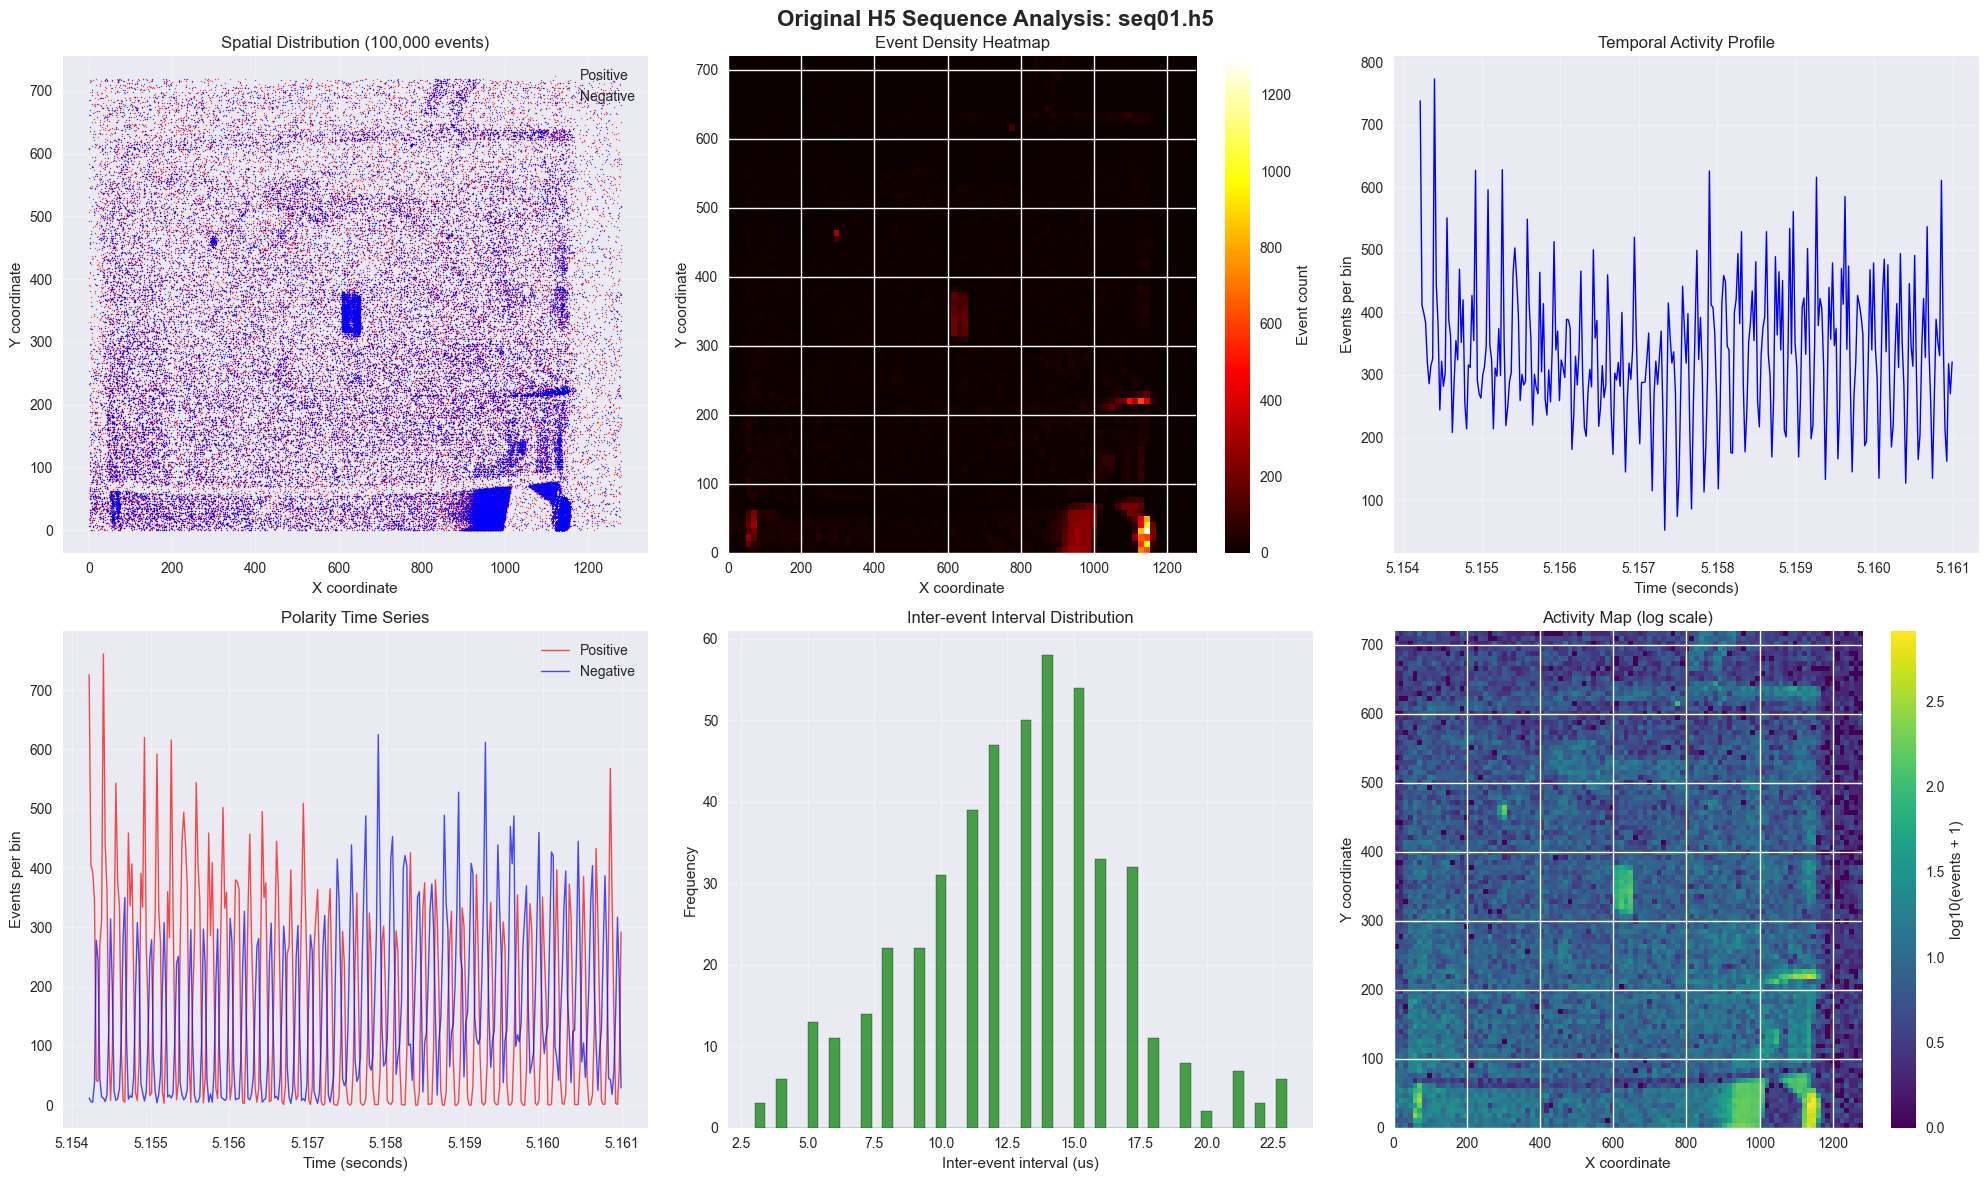

Sequence visualization complete!


In [4]:
if xs is not None:
    # Create multi-panel visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Original H5 Sequence Analysis: {selected_sequence.name}', fontsize=16, fontweight='bold')
    
    # Convert timestamps to seconds for visualization
    ts_seconds = ts / 1_000_000.0
    
    # Sample events for visualization performance
    sample_size = min(100000, len(xs))
    sample_indices = np.random.choice(len(xs), sample_size, replace=False)
    xs_sample = xs[sample_indices]
    ys_sample = ys[sample_indices]
    ts_sample = ts_seconds[sample_indices]
    ps_sample = ps[sample_indices]
    
    # 1. Spatial distribution
    ax1 = axes[0, 0]
    pos_mask = ps_sample == 1
    neg_mask = ps_sample == 0
    
    if np.sum(pos_mask) > 0:
        ax1.scatter(xs_sample[pos_mask], ys_sample[pos_mask], 
                   c='red', s=0.5, alpha=0.6, label='Positive')
    if np.sum(neg_mask) > 0:
        ax1.scatter(xs_sample[neg_mask], ys_sample[neg_mask], 
                   c='blue', s=0.5, alpha=0.6, label='Negative')
    
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    ax1.set_title(f'Spatial Distribution ({sample_size:,} events)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Event density heatmap
    ax2 = axes[0, 1]
    hist, xedges, yedges = np.histogram2d(xs_sample, ys_sample, bins=80)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax2.imshow(hist.T, extent=extent, origin='lower', cmap='hot', aspect='auto')
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')
    ax2.set_title('Event Density Heatmap')
    plt.colorbar(im, ax=ax2, label='Event count')
    
    # 3. Temporal activity
    ax3 = axes[0, 2]
    time_bins = np.linspace(ts_seconds.min(), ts_seconds.max(), 300)
    event_counts, _ = np.histogram(ts_seconds, bins=time_bins)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    
    ax3.plot(bin_centers, event_counts, 'b-', linewidth=1)
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Events per bin')
    ax3.set_title('Temporal Activity Profile')
    ax3.grid(True, alpha=0.3)
    
    # 4. Polarity time series
    ax4 = axes[1, 0]
    pos_counts, _ = np.histogram(ts_seconds[ps == 1], bins=time_bins)
    neg_counts, _ = np.histogram(ts_seconds[ps == 0], bins=time_bins)
    
    ax4.plot(bin_centers, pos_counts, 'r-', linewidth=1, label='Positive', alpha=0.7)
    ax4.plot(bin_centers, neg_counts, 'b-', linewidth=1, label='Negative', alpha=0.7)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Events per bin')
    ax4.set_title('Polarity Time Series')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Event intervals
    ax5 = axes[1, 1]
    # Sample for performance
    ts_sorted = np.sort(ts[::200])  # Every 200th event
    intervals = np.diff(ts_sorted)  # Keep in microseconds
    intervals = intervals[intervals < np.percentile(intervals, 95)]  # Remove outliers
    
    ax5.hist(intervals, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax5.set_xlabel('Inter-event interval (us)')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Inter-event Interval Distribution')
    ax5.grid(True, alpha=0.3)
    
    # 6. Activity regions
    ax6 = axes[1, 2]
    # Create activity map (log scale for better visualization)
    activity_map, xedges, yedges = np.histogram2d(xs, ys, bins=100)
    activity_map = np.log10(activity_map + 1)  # Log scale
    
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax6.imshow(activity_map.T, extent=extent, origin='lower', cmap='viridis', aspect='auto')
    ax6.set_xlabel('X coordinate')
    ax6.set_ylabel('Y coordinate')
    ax6.set_title('Activity Map (log scale)')
    plt.colorbar(im, ax=ax6, label='log10(events + 1)')
    
    plt.tight_layout()
    plt.show()
    
    print("Sequence visualization complete!")
else:
    print("No data to visualize")

## 4. Multi-Sequence Comparison

Compare multiple sequences to understand dataset diversity and characteristics.

In [ ]:
# Compare multiple sequences to understand dataset diversity
sequences_to_analyze = h5_files[:min(5, len(h5_files))]  # Analyze first 5 sequences
comparison_data = []

print("Multi-Sequence Analysis")
print("Analyzing multiple sequences for comparative statistics...")

for i, seq_file in enumerate(sequences_to_analyze):
    print(f"Processing {seq_file.name} ({i+1}/{len(sequences_to_analyze)})...")
    
    try:
        # Load a sample from each sequence for comparison
        xs_seq, ys_seq, ts_seq, ps_seq = evlib.load_events(str(seq_file))
        
        if len(xs_seq) > 0:
            # Use a smaller sample for performance
            sample_size = min(50000, len(xs_seq))
            xs_sample = xs_seq[:sample_size]
            ys_sample = ys_seq[:sample_size]
            ts_sample = ts_seq[:sample_size]
            ps_sample = ps_seq[:sample_size]
            
            # Calculate statistics
            duration = ts_sample.max() - ts_sample.min()
            event_rate = len(xs_sample) / duration if duration > 0 else 0
            pos_ratio = np.sum(ps_sample == 1) / len(ps_sample)
            
            # Spatial characteristics
            spatial_activity = len(np.unique(list(zip(xs_sample, ys_sample))))
            spatial_coverage = spatial_activity / ((xs_sample.max() - xs_sample.min() + 1) * (ys_sample.max() - ys_sample.min() + 1))
            
            comparison_data.append({
                'sequence': seq_file.name,
                'events': len(xs_sample),
                'full_events': len(xs_seq),
                'duration': duration,
                'event_rate': event_rate,
                'pos_ratio': pos_ratio,
                'width': xs_sample.max() - xs_sample.min() + 1,
                'height': ys_sample.max() - ys_sample.min() + 1,
                'spatial_activity': spatial_activity,
                'spatial_coverage': spatial_coverage,
                'file_size_mb': seq_file.stat().st_size / (1024**2)
            })
            
        else:
            print(f"  Warning: No events found in {seq_file.name}")
            
    except Exception as e:
        print(f"  Error processing {seq_file.name}: {e}")

# Create comparison DataFrame
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    
    print(f"\nComparison Summary for {len(df_comparison)} sequences:")
    print("="*60)
    
    # Display summary statistics
    numeric_cols = ['events', 'full_events', 'duration', 'event_rate', 'pos_ratio', 
                   'width', 'height', 'spatial_coverage', 'file_size_mb']
    
    summary_stats = df_comparison[numeric_cols].describe()
    print("Statistical Summary:")
    print(summary_stats.round(2))
    
    # Create comparative visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Multi-Sequence Comparison Analysis', fontsize=16, fontweight='bold')
    
    # 1. Event counts
    ax1 = axes[0, 0]
    ax1.bar(range(len(df_comparison)), df_comparison['events'], alpha=0.7, color='skyblue')
    ax1.set_xlabel('Sequence Index')
    ax1.set_ylabel('Sample Event Count')
    ax1.set_title('Event Counts Across Sequences')
    ax1.grid(True, alpha=0.3)
    
    # 2. Event rates
    ax2 = axes[0, 1]
    ax2.bar(range(len(df_comparison)), df_comparison['event_rate'], alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Sequence Index')
    ax2.set_ylabel('Event Rate (events/time_unit)')
    ax2.set_title('Event Rates Across Sequences')
    ax2.grid(True, alpha=0.3)
    
    # 3. Polarity balance
    ax3 = axes[0, 2]
    ax3.bar(range(len(df_comparison)), df_comparison['pos_ratio'], alpha=0.7, color='coral')
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Perfect balance')
    ax3.set_xlabel('Sequence Index')
    ax3.set_ylabel('Positive Event Ratio')
    ax3.set_title('Polarity Balance Across Sequences')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Spatial coverage
    ax4 = axes[1, 0]
    ax4.bar(range(len(df_comparison)), df_comparison['spatial_coverage'], alpha=0.7, color='gold')
    ax4.set_xlabel('Sequence Index')
    ax4.set_ylabel('Spatial Coverage Ratio')
    ax4.set_title('Spatial Activity Coverage')
    ax4.grid(True, alpha=0.3)
    
    # 5. File sizes
    ax5 = axes[1, 1]
    ax5.bar(range(len(df_comparison)), df_comparison['file_size_mb'], alpha=0.7, color='plum')
    ax5.set_xlabel('Sequence Index')
    ax5.set_ylabel('File Size (MB)')
    ax5.set_title('File Sizes Across Sequences')
    ax5.grid(True, alpha=0.3)
    
    # 6. Event rate vs file size correlation
    ax6 = axes[1, 2]
    ax6.scatter(df_comparison['file_size_mb'], df_comparison['event_rate'], 
               alpha=0.7, s=100, color='purple')
    ax6.set_xlabel('File Size (MB)')
    ax6.set_ylabel('Event Rate (events/time_unit)')
    ax6.set_title('Event Rate vs File Size')
    ax6.grid(True, alpha=0.3)
    
    # Add sequence labels
    for ax in axes.flat:
        if ax.get_title() != 'Event Rate vs File Size':
            ax.set_xticks(range(len(df_comparison)))
            ax.set_xticklabels([f'seq{i+1}' for i in range(len(df_comparison))], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSequence-by-Sequence Details:")
    for _, row in df_comparison.iterrows():
        print(f"{row['sequence']}: {row['full_events']:,} events, "
              f"{row['event_rate']:.0f} events/time_unit, "
              f"{row['pos_ratio']:.3f} pos_ratio, "
              f"{row['file_size_mb']:.1f} MB")
    
else:
    print("No sequence data available for comparison")

## 5. Filtering and Processing Demo

Demonstrate advanced filtering capabilities on the original H5 data.

In [ ]:
# Demonstrate filtering capabilities on the loaded data
if xs is not None:
    print("Advanced Filtering and Processing Demo")
    print("="*50)
    
    original_count = len(xs)
    print(f"Original dataset: {original_count:,} events")
    
    # 1. Temporal filtering
    print("\n1. Temporal Filtering:")
    time_duration = ts.max() - ts.min()
    mid_time = ts.min() + time_duration / 2
    time_window = time_duration / 4  # Quarter of the sequence
    
    time_mask = (ts >= mid_time - time_window/2) & (ts <= mid_time + time_window/2)
    xs_time_filt = xs[time_mask]
    ys_time_filt = ys[time_mask]
    ts_time_filt = ts[time_mask]
    ps_time_filt = ps[time_mask]
    
    print(f"  Time window: [{mid_time - time_window/2:.3f}, {mid_time + time_window/2:.3f}]")
    print(f"  Filtered events: {len(xs_time_filt):,} ({100*len(xs_time_filt)/original_count:.1f}%)")
    
    # 2. Spatial filtering
    print("\n2. Spatial Filtering:")
    x_center = (xs.max() + xs.min()) // 2
    y_center = (ys.max() + ys.min()) // 2
    roi_size = min(xs.max() - xs.min(), ys.max() - ys.min()) // 3
    
    spatial_mask = ((xs >= x_center - roi_size//2) & (xs <= x_center + roi_size//2) &
                   (ys >= y_center - roi_size//2) & (ys <= y_center + roi_size//2))
    
    xs_spatial_filt = xs[spatial_mask]
    ys_spatial_filt = ys[spatial_mask]
    ts_spatial_filt = ts[spatial_mask]
    ps_spatial_filt = ps[spatial_mask]
    
    print(f"  ROI center: ({x_center}, {y_center})")
    print(f"  ROI size: {roi_size} x {roi_size}")
    print(f"  Filtered events: {len(xs_spatial_filt):,} ({100*len(xs_spatial_filt)/original_count:.1f}%)")
    
    # 3. Polarity filtering
    print("\n3. Polarity Filtering:")
    pos_mask = ps == 1
    neg_mask = ps == 0
    
    pos_events = np.sum(pos_mask)
    neg_events = np.sum(neg_mask)
    
    print(f"  Positive events: {pos_events:,} ({100*pos_events/original_count:.1f}%)")
    print(f"  Negative events: {neg_events:,} ({100*neg_events/original_count:.1f}%)")
    
    # 4. Combined filtering
    print("\n4. Combined Filtering (Time + Spatial + Polarity):")
    combined_mask = time_mask & spatial_mask & pos_mask
    xs_combined = xs[combined_mask]
    ys_combined = ys[combined_mask]
    ts_combined = ts[combined_mask]
    ps_combined = ps[combined_mask]
    
    print(f"  Combined filter events: {len(xs_combined):,} ({100*len(xs_combined)/original_count:.1f}%)")
    
    # 5. Activity-based filtering
    print("\n5. Activity-Based Filtering:")
    # Create activity map
    activity_map, x_edges, y_edges = np.histogram2d(xs, ys, bins=50)
    activity_threshold = np.percentile(activity_map.flatten(), 75)  # Top 25% most active regions
    
    # Find high-activity regions
    x_indices = np.digitize(xs, x_edges) - 1
    y_indices = np.digitize(ys, y_edges) - 1
    
    # Ensure indices are within bounds
    x_indices = np.clip(x_indices, 0, activity_map.shape[0] - 1)
    y_indices = np.clip(y_indices, 0, activity_map.shape[1] - 1)
    
    activity_values = activity_map[x_indices, y_indices]
    activity_mask = activity_values > activity_threshold
    
    xs_activity = xs[activity_mask]
    ys_activity = ys[activity_mask]
    ts_activity = ts[activity_mask]
    ps_activity = ps[activity_mask]
    
    print(f"  Activity threshold: {activity_threshold:.1f} events per bin")
    print(f"  High-activity events: {len(xs_activity):,} ({100*len(xs_activity)/original_count:.1f}%)")
    
    # Visualization of filtering results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Filtering and Processing Results', fontsize=16, fontweight='bold')
    
    # Original data
    ax1 = axes[0, 0]
    pos_orig = ps == 1
    neg_orig = ps == 0
    if np.sum(pos_orig) > 0:
        ax1.scatter(xs[pos_orig], ys[pos_orig], c='red', s=0.5, alpha=0.6, label='Positive')
    if np.sum(neg_orig) > 0:
        ax1.scatter(xs[neg_orig], ys[neg_orig], c='blue', s=0.5, alpha=0.6, label='Negative')
    ax1.set_title(f'Original Data ({len(xs):,} events)')
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Temporal filtering
    ax2 = axes[0, 1]
    pos_time = ps_time_filt == 1
    neg_time = ps_time_filt == 0
    if np.sum(pos_time) > 0:
        ax2.scatter(xs_time_filt[pos_time], ys_time_filt[pos_time], c='red', s=0.5, alpha=0.6)
    if np.sum(neg_time) > 0:
        ax2.scatter(xs_time_filt[neg_time], ys_time_filt[neg_time], c='blue', s=0.5, alpha=0.6)
    ax2.set_title(f'Temporal Filter ({len(xs_time_filt):,} events)')
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')
    ax2.grid(True, alpha=0.3)
    
    # Spatial filtering
    ax3 = axes[0, 2]
    pos_spatial = ps_spatial_filt == 1
    neg_spatial = ps_spatial_filt == 0
    if np.sum(pos_spatial) > 0:
        ax3.scatter(xs_spatial_filt[pos_spatial], ys_spatial_filt[pos_spatial], c='red', s=0.5, alpha=0.6)
    if np.sum(neg_spatial) > 0:
        ax3.scatter(xs_spatial_filt[neg_spatial], ys_spatial_filt[neg_spatial], c='blue', s=0.5, alpha=0.6)
    
    # Add ROI rectangle
    from matplotlib.patches import Rectangle
    roi_rect = Rectangle((x_center - roi_size//2, y_center - roi_size//2), 
                        roi_size, roi_size, linewidth=2, edgecolor='green', 
                        facecolor='none', label='ROI')
    ax3.add_patch(roi_rect)
    ax3.set_title(f'Spatial Filter ({len(xs_spatial_filt):,} events)')
    ax3.set_xlabel('X coordinate')
    ax3.set_ylabel('Y coordinate')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Activity-based filtering
    ax4 = axes[1, 0]
    im = ax4.imshow(activity_map.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], 
                   origin='lower', cmap='hot', aspect='auto')
    ax4.set_title('Activity Map')
    ax4.set_xlabel('X coordinate')
    ax4.set_ylabel('Y coordinate')
    plt.colorbar(im, ax=ax4, label='Event count')
    
    # Combined filtering
    ax5 = axes[1, 1]
    if len(xs_combined) > 0:
        ax5.scatter(xs_combined, ys_combined, c='purple', s=1, alpha=0.7)
    ax5.set_title(f'Combined Filter ({len(xs_combined):,} events)')
    ax5.set_xlabel('X coordinate')
    ax5.set_ylabel('Y coordinate')
    ax5.grid(True, alpha=0.3)
    
    # Filtering summary
    ax6 = axes[1, 2]
    filter_names = ['Original', 'Temporal', 'Spatial', 'Activity', 'Combined']
    filter_counts = [original_count, len(xs_time_filt), len(xs_spatial_filt), 
                    len(xs_activity), len(xs_combined)]
    filter_percentages = [100 * count / original_count for count in filter_counts]
    
    bars = ax6.bar(filter_names, filter_percentages, alpha=0.7, 
                  color=['gray', 'blue', 'green', 'orange', 'purple'])
    ax6.set_ylabel('Percentage of Original Events')
    ax6.set_title('Filtering Effectiveness')
    ax6.set_ylim(0, 105)
    ax6.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, percentage in zip(bars, filter_percentages):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{percentage:.1f}%', ha='center', va='bottom')
    
    plt.setp(ax6.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nFiltering Summary:")
    print(f"  Original events: {original_count:,}")
    print(f"  After temporal filter: {len(xs_time_filt):,} ({100*len(xs_time_filt)/original_count:.1f}%)")
    print(f"  After spatial filter: {len(xs_spatial_filt):,} ({100*len(xs_spatial_filt)/original_count:.1f}%)")
    print(f"  After activity filter: {len(xs_activity):,} ({100*len(xs_activity)/original_count:.1f}%)")
    print(f"  After combined filter: {len(xs_combined):,} ({100*len(xs_combined)/original_count:.1f}%)")
    
else:
    print("No event data available for filtering demonstration")

## 6. Event Histogram Creation

Create spatiotemporal event histogram representations from the original H5 data.

In [ ]:
# Create spatiotemporal event histogram representations from the event data
if xs is not None:
    print("Event Histogram Creation and Analysis")
    print("="*40)
    
    # Calculate appropriate dimensions
    sensor_width = xs.max() - xs.min() + 1
    sensor_height = ys.max() - ys.min() + 1
    time_duration = ts.max() - ts.min()
    
    print(f"Event data characteristics:")
    print(f"  Sensor dimensions: {sensor_width} x {sensor_height}")
    print(f"  Time duration: {time_duration:.3f} time units")
    print(f"  Total events: {len(xs):,}")
    
    # Create event histograms with different configurations
    histogram_configs = [
        {'name': 'Coarse Spatial', 'width': 64, 'height': 48, 'bins': 5},
        {'name': 'Fine Spatial', 'width': 128, 'height': 96, 'bins': 5},
        {'name': 'High Temporal', 'width': 64, 'height': 48, 'bins': 10},
        {'name': 'Balanced', 'width': 96, 'height': 72, 'bins': 8}
    ]
    
    histogram_results = []
    
    print("\nCreating event histograms with different configurations...")
    
    for config in histogram_configs:
        print(f"\nConfiguration: {config['name']}")
        print(f"  Dimensions: {config['width']} x {config['height']} x {config['bins']}")
        
        # Convert polarity to binary for compatibility
        ps_binary = np.where(ps == 1, 1, 0)
        
        # Use evlib to create stacked histogram (RVT-style)
        histogram = evlib.stacked_histogram(
            xs, ys, ps_binary, ts,
            bins=config['bins'],
            height=config['height'],
            width=config['width']
        )
        
        if histogram is not None:
            print(f"  Histogram shape: {histogram.shape}")
            print(f"  Value range: [{histogram.min():.3f}, {histogram.max():.3f}]")
            print(f"  Non-zero pixels: {np.count_nonzero(histogram):,}")
            print(f"  Sparsity: {100 * (1 - np.count_nonzero(histogram) / histogram.size):.1f}%")
            
            histogram_results.append({
                'config': config,
                'histogram': histogram,
                'non_zero_count': np.count_nonzero(histogram),
                'sparsity': 100 * (1 - np.count_nonzero(histogram) / histogram.size),
                'value_range': (histogram.min(), histogram.max())
            })
        else:
            print(f"  Error: Failed to create histogram")
    
    # Visualize histograms
    if histogram_results:
        print(f"\nCreated {len(histogram_results)} histograms successfully")
        
        # Create visualization
        fig, axes = plt.subplots(2, len(histogram_results), figsize=(5*len(histogram_results), 10))
        if len(histogram_results) == 1:
            axes = axes.reshape(-1, 1)
        fig.suptitle('Event Histogram Representations', fontsize=16, fontweight='bold')
        
        for i, result in enumerate(histogram_results):
            histogram = result['histogram']
            config = result['config']
            
            # Temporal average view (collapse temporal dimension)
            ax1 = axes[0, i]
            temporal_avg = np.mean(histogram, axis=0)
            im1 = ax1.imshow(temporal_avg.T, cmap='viridis', origin='lower', aspect='auto')
            ax1.set_title(f"{config['name']}\nTemporal Average")
            ax1.set_xlabel('X (pixel)')
            ax1.set_ylabel('Y (pixel)')
            plt.colorbar(im1, ax=ax1, label='Average activity')
            
            # Temporal profile (collapse spatial dimensions)
            ax2 = axes[1, i]
            temporal_profile = np.sum(histogram, axis=(1, 2))
            ax2.plot(range(len(temporal_profile)), temporal_profile, 'b-', linewidth=2)
            ax2.set_title(f"{config['name']}\nTemporal Profile")
            ax2.set_xlabel('Temporal bin')
            ax2.set_ylabel('Total activity')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Analysis summary
        print("\nEvent Histogram Analysis Summary:")
        print("="*50)
        
        comparison_df = pd.DataFrame([
            {
                'Configuration': result['config']['name'],
                'Dimensions': f"{result['config']['width']}x{result['config']['height']}x{result['config']['bins']}",
                'Total Pixels': result['histogram'].size,
                'Non-zero Pixels': result['non_zero_count'],
                'Sparsity (%)': result['sparsity'],
                'Min Value': result['value_range'][0],
                'Max Value': result['value_range'][1]
            }
            for result in histogram_results
        ])
        
        print(comparison_df.to_string(index=False, float_format='%.3f'))
        
        # Create comparison visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Event Histogram Configuration Comparison', fontsize=14, fontweight='bold')
        
        configs = [r['config']['name'] for r in histogram_results]
        
        # Sparsity comparison
        ax1 = axes[0]
        sparsities = [r['sparsity'] for r in histogram_results]
        bars1 = ax1.bar(configs, sparsities, alpha=0.7, color='skyblue')
        ax1.set_ylabel('Sparsity (%)')
        ax1.set_title('Sparsity Comparison')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars1, sparsities):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        # Non-zero pixel count
        ax2 = axes[1]
        nonzero_counts = [r['non_zero_count'] for r in histogram_results]
        bars2 = ax2.bar(configs, nonzero_counts, alpha=0.7, color='lightgreen')
        ax2.set_ylabel('Non-zero Pixels')
        ax2.set_title('Information Density')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars2, nonzero_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + max(nonzero_counts)*0.01,
                    f'{value:,}', ha='center', va='bottom')
        
        # Value range comparison
        ax3 = axes[2]
        max_values = [r['value_range'][1] for r in histogram_results]
        bars3 = ax3.bar(configs, max_values, alpha=0.7, color='coral')
        ax3.set_ylabel('Maximum Value')
        ax3.set_title('Dynamic Range')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars3, max_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(max_values)*0.01,
                    f'{value:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Recommendations
        print("\nRecommendations:")
        best_sparsity = min(histogram_results, key=lambda x: x['sparsity'])
        best_info_density = max(histogram_results, key=lambda x: x['non_zero_count'])
        
        print(f"  • Lowest sparsity (most dense): {best_sparsity['config']['name']} ({best_sparsity['sparsity']:.1f}% sparse)")
        print(f"  • Highest information density: {best_info_density['config']['name']} ({best_info_density['non_zero_count']:,} non-zero pixels)")
        print(f"  • For real-time applications: Consider coarse spatial resolution with fewer temporal bins")
        print(f"  • For detailed analysis: Use fine spatial resolution with high temporal resolution")
        
    else:
        print("No histograms were created successfully")
        
else:
    print("No event data available for histogram creation")

## 7. Performance Benchmarking

Benchmark the performance of different operations on the original H5 data.

In [ ]:
# Benchmark performance of different operations on the H5 data
import time

if h5_files:
    print("Performance Benchmarking on Original H5 Data")
    print("="*50)
    
    # Select files for benchmarking
    benchmark_files = h5_files[:min(3, len(h5_files))]  # Test first 3 files
    benchmark_results = []
    
    print(f"Benchmarking {len(benchmark_files)} H5 files...")
    
    for i, h5_file in enumerate(benchmark_files):
        print(f"\nBenchmarking {h5_file.name} ({i+1}/{len(benchmark_files)})...")
        
        file_results = {
            'filename': h5_file.name,
            'file_size_mb': h5_file.stat().st_size / (1024**2)
        }
        
        # 1. Data loading benchmark
        print("  Testing data loading...")
        start_time = time.time()
        xs_bench, ys_bench, ts_bench, ps_bench = evlib.load_events(str(h5_file))
        load_time = time.time() - start_time
        
        if len(xs_bench) > 0:
            events_count = len(xs_bench)
            file_results.update({
                'events_count': events_count,
                'load_time': load_time,
                'load_rate': events_count / load_time,
                'load_throughput_mb_s': file_results['file_size_mb'] / load_time
            })
            
            print(f"    Loaded {events_count:,} events in {load_time:.2f}s")
            print(f"    Load rate: {events_count/load_time:.0f} events/s")
            print(f"    Throughput: {file_results['file_size_mb']/load_time:.1f} MB/s")
            
            # Use a sample for subsequent benchmarks
            sample_size = min(100000, events_count)
            xs_sample = xs_bench[:sample_size]
            ys_sample = ys_bench[:sample_size]
            ts_sample = ts_bench[:sample_size]
            ps_sample = ps_bench[:sample_size]
            
            # 2. Event histogram creation benchmark
            print("  Testing event histogram creation...")
            start_time = time.time()
            ps_binary = np.where(ps_sample == 1, 1, 0)
            histogram = evlib.stacked_histogram(
                xs_sample, ys_sample, ps_binary, ts_sample,
                bins=5, height=64, width=64
            )
            histogram_time = time.time() - start_time
            
            if histogram is not None:
                file_results.update({
                    'histogram_time': histogram_time,
                    'histogram_rate': sample_size / histogram_time,
                    'histogram_size': histogram.size
                })
                
                print(f"    Created histogram in {histogram_time:.3f}s")
                print(f"    Histogram processing rate: {sample_size/histogram_time:.0f} events/s")
                print(f"    Histogram shape: {histogram.shape}")
            
            # 3. Filtering benchmark
            print("  Testing spatial filtering...")
            start_time = time.time()
            
            # Apply spatial filter
            x_center = (xs_sample.max() + xs_sample.min()) // 2
            y_center = (ys_sample.max() + ys_sample.min()) // 2
            roi_size = min(xs_sample.max() - xs_sample.min(), ys_sample.max() - ys_sample.min()) // 3
            
            spatial_mask = ((xs_sample >= x_center - roi_size//2) & 
                           (xs_sample <= x_center + roi_size//2) &
                           (ys_sample >= y_center - roi_size//2) & 
                           (ys_sample <= y_center + roi_size//2))
            
            xs_filtered = xs_sample[spatial_mask]
            ys_filtered = ys_sample[spatial_mask]
            ts_filtered = ts_sample[spatial_mask]
            ps_filtered = ps_sample[spatial_mask]
            
            filter_time = time.time() - start_time
            
            file_results.update({
                'filter_time': filter_time,
                'filter_rate': sample_size / filter_time,
                'filtered_events': len(xs_filtered),
                'filter_retention': len(xs_filtered) / sample_size
            })
            
            print(f"    Filtered {sample_size:,} events in {filter_time:.4f}s")
            print(f"    Filter processing rate: {sample_size/filter_time:.0f} events/s")
            print(f"    Retained {len(xs_filtered):,} events ({100*len(xs_filtered)/sample_size:.1f}%)")
            
            # 4. Statistical analysis benchmark
            print("  Testing statistical analysis...")
            start_time = time.time()
            
            # Basic statistics
            stats = {
                'mean_x': np.mean(xs_sample),
                'mean_y': np.mean(ys_sample),
                'std_x': np.std(xs_sample),
                'std_y': np.std(ys_sample),
                'pos_ratio': np.mean(ps_sample),
                'event_rate': len(xs_sample) / (ts_sample.max() - ts_sample.min()),
                'spatial_extent': (xs_sample.max() - xs_sample.min()) * (ys_sample.max() - ys_sample.min())
            }
            
            # Create histogram
            hist, _, _ = np.histogram2d(xs_sample, ys_sample, bins=50)
            
            stats_time = time.time() - start_time
            
            file_results.update({
                'stats_time': stats_time,
                'stats_rate': sample_size / stats_time,
                'stats': stats
            })
            
            print(f"    Computed statistics in {stats_time:.4f}s")
            print(f"    Stats processing rate: {sample_size/stats_time:.0f} events/s")
            
            # Calculate overall processing rate
            total_processing_time = load_time + histogram_time + filter_time + stats_time
            file_results['total_time'] = total_processing_time
            file_results['processing_rate'] = events_count / total_processing_time
            
            print(f"    Total processing time: {total_processing_time:.2f}s")
            print(f"    Overall processing rate: {events_count/total_processing_time:.0f} events/s")
            
        else:
            print("    No events found in file")
        
        benchmark_results.append(file_results)
    
    # Analyze benchmark results
    if benchmark_results:
        print("\nBenchmark Results Summary:")
        print("="*60)
        
        # Filter successful benchmarks
        successful_results = [r for r in benchmark_results if 'processing_rate' in r]
        
        if successful_results:
            df_benchmark = pd.DataFrame(successful_results)
            
            # Display summary statistics
            print("Performance Metrics:")
            
            performance_cols = ['load_rate', 'histogram_rate', 'filter_rate', 'stats_rate', 'processing_rate']
            available_cols = [col for col in performance_cols if col in df_benchmark.columns]
            
            if available_cols:
                perf_summary = df_benchmark[available_cols].describe()
                print(perf_summary.round(0))
                
                # Create performance visualization
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                fig.suptitle('Performance Benchmark Results', fontsize=16, fontweight='bold')
                
                # 1. Processing rates comparison
                ax1 = axes[0, 0]
                x_pos = np.arange(len(df_benchmark))
                width = 0.15
                
                if 'load_rate' in df_benchmark.columns:
                    ax1.bar(x_pos - 2*width, df_benchmark['load_rate'], width, 
                           alpha=0.7, label='Load Rate', color='skyblue')
                if 'histogram_rate' in df_benchmark.columns:
                    ax1.bar(x_pos - width, df_benchmark['histogram_rate'], width, 
                           alpha=0.7, label='Histogram Rate', color='lightgreen')
                if 'filter_rate' in df_benchmark.columns:
                    ax1.bar(x_pos, df_benchmark['filter_rate'], width, 
                           alpha=0.7, label='Filter Rate', color='coral')
                if 'stats_rate' in df_benchmark.columns:
                    ax1.bar(x_pos + width, df_benchmark['stats_rate'], width, 
                           alpha=0.7, label='Stats Rate', color='gold')
                if 'processing_rate' in df_benchmark.columns:
                    ax1.bar(x_pos + 2*width, df_benchmark['processing_rate'], width, 
                           alpha=0.7, label='Overall Rate', color='purple')
                
                ax1.set_xlabel('File Index')
                ax1.set_ylabel('Events/Second')
                ax1.set_title('Processing Rates Comparison')
                ax1.set_xticks(x_pos)
                ax1.set_xticklabels([f'File {i+1}' for i in range(len(df_benchmark))])
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # 2. File size vs processing rate
                ax2 = axes[0, 1]
                if 'file_size_mb' in df_benchmark.columns and 'processing_rate' in df_benchmark.columns:
                    ax2.scatter(df_benchmark['file_size_mb'], df_benchmark['processing_rate'], 
                               alpha=0.7, s=100, color='red')
                    ax2.set_xlabel('File Size (MB)')
                    ax2.set_ylabel('Processing Rate (events/s)')
                    ax2.set_title('File Size vs Processing Rate')
                    ax2.grid(True, alpha=0.3)
                
                # 3. Time breakdown
                ax3 = axes[1, 0]
                time_cols = ['load_time', 'histogram_time', 'filter_time', 'stats_time']
                available_time_cols = [col for col in time_cols if col in df_benchmark.columns]
                
                if available_time_cols:
                    avg_times = df_benchmark[available_time_cols].mean()
                    colors = ['skyblue', 'lightgreen', 'coral', 'gold']
                    bars = ax3.bar(range(len(avg_times)), avg_times, 
                                  alpha=0.7, color=colors[:len(avg_times)])
                    ax3.set_xlabel('Operation')
                    ax3.set_ylabel('Average Time (seconds)')
                    ax3.set_title('Average Processing Time Breakdown')
                    ax3.set_xticks(range(len(avg_times)))
                    ax3.set_xticklabels([col.replace('_time', '').title() for col in available_time_cols])
                    ax3.grid(True, alpha=0.3)
                    
                    # Add value labels on bars
                    for bar, value in zip(bars, avg_times):
                        height = bar.get_height()
                        ax3.text(bar.get_x() + bar.get_width()/2., height + max(avg_times)*0.01,
                                f'{value:.3f}s', ha='center', va='bottom')
                
                # 4. Throughput comparison
                ax4 = axes[1, 1]
                if 'load_throughput_mb_s' in df_benchmark.columns:
                    bars = ax4.bar(range(len(df_benchmark)), df_benchmark['load_throughput_mb_s'], 
                                  alpha=0.7, color='purple')
                    ax4.set_xlabel('File Index')
                    ax4.set_ylabel('Throughput (MB/s)')
                    ax4.set_title('File Loading Throughput')
                    ax4.set_xticks(range(len(df_benchmark)))
                    ax4.set_xticklabels([f'File {i+1}' for i in range(len(df_benchmark))])
                    ax4.grid(True, alpha=0.3)
                    
                    # Add value labels on bars
                    for bar, value in zip(bars, df_benchmark['load_throughput_mb_s']):
                        height = bar.get_height()
                        ax4.text(bar.get_x() + bar.get_width()/2., height + max(df_benchmark['load_throughput_mb_s'])*0.01,
                                f'{value:.1f}', ha='center', va='bottom')
                
                plt.tight_layout()
                plt.show()
                
                # Performance insights
                print("\nPerformance Insights:")
                if 'processing_rate' in df_benchmark.columns:
                    avg_rate = df_benchmark['processing_rate'].mean()
                    max_rate = df_benchmark['processing_rate'].max()
                    min_rate = df_benchmark['processing_rate'].min()
                    
                    print(f"  • Average processing rate: {avg_rate:.0f} events/s")
                    print(f"  • Peak processing rate: {max_rate:.0f} events/s")
                    print(f"  • Minimum processing rate: {min_rate:.0f} events/s")
                    print(f"  • Performance variation: {((max_rate-min_rate)/avg_rate)*100:.1f}%")
                
                if 'load_throughput_mb_s' in df_benchmark.columns:
                    avg_throughput = df_benchmark['load_throughput_mb_s'].mean()
                    print(f"  • Average file loading throughput: {avg_throughput:.1f} MB/s")
                
                # Recommendations
                print("\nPerformance Recommendations:")
                if 'load_time' in df_benchmark.columns and 'histogram_time' in df_benchmark.columns:
                    avg_load_time = df_benchmark['load_time'].mean()
                    avg_histogram_time = df_benchmark['histogram_time'].mean()
                    
                    if avg_load_time > avg_histogram_time * 2:
                        print("  • File I/O is the bottleneck - consider faster storage or file format optimization")
                    elif avg_histogram_time > avg_load_time * 2:
                        print("  • Histogram creation is the bottleneck - consider coarser resolution or optimization")
                    else:
                        print("  • Balanced performance across operations")
                
                print("  • For production use, consider parallel processing for multiple files")
                print("  • Memory usage optimization may be needed for very large files")
                
            else:
                print("No performance metrics available")
        else:
            print("No successful benchmark results to analyze")
    
else:
    print("No H5 files available for benchmarking")